### Import packages

In [1]:
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from utilities import cal_score, convert_types

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Columns

In [2]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_feats = cols_num + cols_cat + cols_bin

col_target = 'total_price'
col_target_log1p = 'target'

### Read data

In [3]:
df = pd.read_csv('dataset/train.csv', dtype=object)

In [4]:
df.columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

### Preprocessing

In [5]:
# Convert types
df = convert_types(df, cols_num, col_target=col_target)

# Generate feats (train-test-same feats)
#create_feats(df)

### Feat engineering

In [6]:
from feature_engineering import CategoricalColumnsEncoder

In [7]:
class FeatureEngineering():
    def __init__(self):
        pass
    
    def fit_transform(self, df, cols_cat, cols_bin):
        df = df.copy()
        # Denote categorical-type
        self.cat_encoder = CategoricalColumnsEncoder(mode='pandas')
        self.cat_encoder.fit_transform(df, cols_cat+cols_bin)
        return df
    
    def transform(self, df):
        df = df.copy()
        self.cat_encoder.transform(df)
        return df

### Grid search

In [8]:
# pars
is_log1p = True # if train on log1p target
# pars

# grid search
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.015,
              }

#### Round 1

In [9]:
%%time
params_gsearch1 = {'num_leaves': [63, 255, 511],           # may reduce in dim-reduction exp
                   'feature_fraction': [0.5, 0.75, 1.0],
                   'min_data_in_leaf': [5, 20, 50]
                   }

gsearch = {}
folds = KFold(n_splits=3, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    if is_log1p:
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train['target']).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val['target'], reference=lgb_train).construct()
    else:
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train['total_price']).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val['total_price'], reference=lgb_train).construct()
        
    # grid search
    for values in itertools.product(*[params_gsearch1[key] for key in params_gsearch1]):
        params = params_fix.copy()
        params.update( dict(zip(params_gsearch1.keys(), values)) )
        print('params:', params)

        model = lgb.train(params, lgb_train,
                          num_boost_round=10000,
                          valid_sets=lgb_val,
                          verbose_eval=2000,
                          early_stopping_rounds=200)
        y_pred = model.predict(df_val[cols_feats])
        
        if is_log1p:
            y_pred_expm1 = np.expm1(y_pred)
            y_pred_final = np.clip(y_pred_expm1, 0, None)
        else:
            y_pred_final = y_pred
            
        score = cal_score(df_val['total_price'], y_pred_final)
        tuple_params = tuple(params.items())
        gsearch[tuple_params] = gsearch.get(tuple_params, []) + [score]

# aggregate, sort gsearch results
gsearch_results1 = [[key, np.mean(val), val] for key, val in gsearch.items()]
gsearch_results1.sort(key= lambda x: x[1], reverse=True)
display(gsearch_results1)

==== Fold 1 ====
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 63, 'feature_fraction': 0.5, 'min_data_in_leaf': 5}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00924973
[4000]	valid_0's mape: 0.00889486
[6000]	valid_0's mape: 0.00873562
[8000]	valid_0's mape: 0.00864773
[10000]	valid_0's mape: 0.00859924
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00859924
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 63, 'feature_fraction': 0.5, 'min_data_in_leaf': 20}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00922818
[4000]	valid_0's mape: 0.00887349
[6000]	valid_0's mape: 0.00872457
[8000]	valid_0's mape: 0.0086457
[10000]	valid_0's mape: 0.00859651
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.

[8000]	valid_0's mape: 0.00882928
[10000]	valid_0's mape: 0.00882544
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00882543
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 1.0, 'min_data_in_leaf': 50}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00898723
[4000]	valid_0's mape: 0.00889822
[6000]	valid_0's mape: 0.008884
Early stopping, best iteration is:
[6852]	valid_0's mape: 0.00888083
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 511, 'feature_fraction': 0.5, 'min_data_in_leaf': 5}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00871849
[4000]	valid_0's mape: 0.00867427
[6000]	valid_0's mape: 0.00866703
[8000]	valid_0's mape: 0.00866505
[10000]	valid_0's mape: 0.00866433
Did not meet early sto

[2000]	valid_0's mape: 0.00947864
[4000]	valid_0's mape: 0.00914916
[6000]	valid_0's mape: 0.00901362
[8000]	valid_0's mape: 0.00894544
[10000]	valid_0's mape: 0.00890538
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00890538
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 63, 'feature_fraction': 1.0, 'min_data_in_leaf': 50}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00949095
[4000]	valid_0's mape: 0.00918489
[6000]	valid_0's mape: 0.00905474
[8000]	valid_0's mape: 0.00899866
[10000]	valid_0's mape: 0.00896628
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00896627
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5}
Training until validation scores don't improve for 200 rounds.
[2000]	

[2000]	valid_0's mape: 0.00898406
[4000]	valid_0's mape: 0.00894599
[6000]	valid_0's mape: 0.00894069
[8000]	valid_0's mape: 0.00893967
[10000]	valid_0's mape: 0.00893939
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00893939
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 511, 'feature_fraction': 1.0, 'min_data_in_leaf': 20}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.0089554
[4000]	valid_0's mape: 0.00892977
[6000]	valid_0's mape: 0.00892525
[8000]	valid_0's mape: 0.00892325
[10000]	valid_0's mape: 0.00892225
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00892225
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 511, 'feature_fraction': 1.0, 'min_data_in_leaf': 50}
Training until validation scores don't improve for 200 rounds.
[2000]

[2000]	valid_0's mape: 0.00882231
[4000]	valid_0's mape: 0.00872889
[6000]	valid_0's mape: 0.00871134
[8000]	valid_0's mape: 0.00870608
[10000]	valid_0's mape: 0.00870444
Did not meet early stopping. Best iteration is:
[9892]	valid_0's mape: 0.00870439
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 1.0, 'min_data_in_leaf': 5}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00905963
[4000]	valid_0's mape: 0.00895269
[6000]	valid_0's mape: 0.00892689
[8000]	valid_0's mape: 0.00891709
[10000]	valid_0's mape: 0.0089136
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.0089136
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 1.0, 'min_data_in_leaf': 20}
Training until validation scores don't improve for 200 rounds.
[2000]	v

[[(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 5)),
  5501.863278855861,
  [5527.864888142274, 5498.864225711784, 5478.860722713526]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.75),
   ('min_data_in_leaf', 5)),
  5487.528884854769,
  [5520.8628564734545, 5464.864074281463, 5476.859723809391]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 20)),
  5486.529382166224,
  [5512.864088908585, 5463.864133470911, 5482.859924119177]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learnin

CPU times: user 3d 3h 24min 9s, sys: 45min 31s, total: 3d 4h 9min 40s
Wall time: 6h 36min 46s


In [31]:
display(gsearch_results1)

[[(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 5)),
  5501.863278855861,
  [5527.864888142274, 5498.864225711784, 5478.860722713526]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.75),
   ('min_data_in_leaf', 5)),
  5487.528884854769,
  [5520.8628564734545, 5464.864074281463, 5476.859723809391]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 20)),
  5486.529382166224,
  [5512.864088908585, 5463.864133470911, 5482.859924119177]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learnin

#### Round 2

In [10]:
%%time
params_gsearch2 = {'lambda_l1': [0, 0.01, 0.1],
                   'lambda_l2': [0, 0.01, 0.1]
                  }

gsearch = {}
folds = KFold(n_splits=3, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    if is_log1p:
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train['target']).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val['target'], reference=lgb_train).construct()
    else:
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train['total_price']).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val['total_price'], reference=lgb_train).construct()
        
    # grid search
    # pick top 5 params from round 1
    for result1 in gsearch_results1[:5]:
        params1 = dict(result1[0])
        for values in itertools.product(*[params_gsearch2[key] for key in params_gsearch2]):
            params = params1.copy()
            params.update( dict(zip(params_gsearch2.keys(), values)) )
            print('params:', params)

            model = lgb.train(params, lgb_train,
                              num_boost_round=10000,
                              valid_sets=lgb_val,
                              verbose_eval=2000,
                              early_stopping_rounds=200)
            y_pred = model.predict(df_val[cols_feats])

            if is_log1p:
                y_pred_expm1 = np.expm1(y_pred)
                y_pred_final = np.clip(y_pred_expm1, 0, None)
            else:
                y_pred_final = y_pred

            score = cal_score(df_val['total_price'], y_pred_final)
            tuple_params = tuple(params.items())
            gsearch[tuple_params] = gsearch.get(tuple_params, []) + [score]

# aggregate, sort gsearch results
gsearch_results2 = [[key, np.mean(val), val] for key, val in gsearch.items()]
gsearch_results2.sort(key= lambda x: x[1], reverse=True)
display(gsearch_results2)

==== Fold 1 ====
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0, 'lambda_l2': 0}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00863224
[4000]	valid_0's mape: 0.00850575
[6000]	valid_0's mape: 0.00847459
[8000]	valid_0's mape: 0.00846379
[10000]	valid_0's mape: 0.00845959
Did not meet early stopping. Best iteration is:
[9986]	valid_0's mape: 0.00845958
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0, 'lambda_l2': 0.01}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00864734
[4000]	valid_0's mape: 0.00852085
[6000]	valid_0's mape: 0.00849028
[8000]	valid_0's mape: 0.00847847
[10000]	valid_0's mape: 0.00847427
Did no

[2000]	valid_0's mape: 0.00871162
[4000]	valid_0's mape: 0.00860455
[6000]	valid_0's mape: 0.00857893
[8000]	valid_0's mape: 0.00856986
[10000]	valid_0's mape: 0.00856629
Did not meet early stopping. Best iteration is:
[9991]	valid_0's mape: 0.00856629
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.75, 'min_data_in_leaf': 5, 'lambda_l1': 0.1, 'lambda_l2': 0.01}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00871564
[4000]	valid_0's mape: 0.00860397
[6000]	valid_0's mape: 0.00857746
[8000]	valid_0's mape: 0.00856801
[10000]	valid_0's mape: 0.00856433
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00856433
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.75, 'min_data_in_leaf': 5, 'lambda_l1': 0.1, 'lambda_l2': 

[2000]	valid_0's mape: 0.0086442
[4000]	valid_0's mape: 0.0085252
[6000]	valid_0's mape: 0.00850274
[8000]	valid_0's mape: 0.00849637
[10000]	valid_0's mape: 0.00849445
Did not meet early stopping. Best iteration is:
[9877]	valid_0's mape: 0.00849441
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 50, 'lambda_l1': 0.01, 'lambda_l2': 0.1}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00862926
[4000]	valid_0's mape: 0.00850968
[6000]	valid_0's mape: 0.00848592
[8000]	valid_0's mape: 0.00847987
[10000]	valid_0's mape: 0.00847817
Did not meet early stopping. Best iteration is:
[9882]	valid_0's mape: 0.00847811
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 50, 'lambda_l1': 0.1, 'lambda_l2': 0}


params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.01, 'lambda_l2': 0}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00876918
[4000]	valid_0's mape: 0.00865114
[6000]	valid_0's mape: 0.00862074
[8000]	valid_0's mape: 0.00860948
[10000]	valid_0's mape: 0.00860468
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00860468
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.01, 'lambda_l2': 0.01}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00877338
[4000]	valid_0's mape: 0.00864699
[6000]	valid_0's mape: 0.00861696
[8000]	valid_0's mape: 0.0086064
[10000]	valid_0's mape: 0.00860157
Did not meet earl

[2000]	valid_0's mape: 0.00876764
[4000]	valid_0's mape: 0.00864607
[6000]	valid_0's mape: 0.0086181
[8000]	valid_0's mape: 0.00860916
[10000]	valid_0's mape: 0.00860596
Did not meet early stopping. Best iteration is:
[9986]	valid_0's mape: 0.00860595
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 20, 'lambda_l1': 0, 'lambda_l2': 0.01}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.008764
[4000]	valid_0's mape: 0.0086409
[6000]	valid_0's mape: 0.0086148
[8000]	valid_0's mape: 0.00860594
[10000]	valid_0's mape: 0.00860215
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00860215
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 20, 'lambda_l1': 0, 'lambda_l2': 0.1}
Trai

[2000]	valid_0's mape: 0.00878667
[4000]	valid_0's mape: 0.00867209
[6000]	valid_0's mape: 0.00864369
[8000]	valid_0's mape: 0.00863463
[10000]	valid_0's mape: 0.00863103
Did not meet early stopping. Best iteration is:
[9993]	valid_0's mape: 0.00863102
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 50, 'lambda_l1': 0.1, 'lambda_l2': 0.1}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.0087832
[4000]	valid_0's mape: 0.00866953
[6000]	valid_0's mape: 0.00864147
[8000]	valid_0's mape: 0.00863218
[10000]	valid_0's mape: 0.00862842
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00862841
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.75, 'min_data_in_leaf': 50, 'lambda_l1': 0, 'lambda_l2': 0}
T

params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.01, 'lambda_l2': 0.1}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00880856
[4000]	valid_0's mape: 0.00867803
[6000]	valid_0's mape: 0.00864501
[8000]	valid_0's mape: 0.00863258
[10000]	valid_0's mape: 0.00862698
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00862698
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.1, 'lambda_l2': 0}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00880534
[4000]	valid_0's mape: 0.0086768
[6000]	valid_0's mape: 0.00864392
[8000]	valid_0's mape: 0.00863107
[10000]	valid_0's mape: 0.00862541
Did not meet early s

[2000]	valid_0's mape: 0.00879783
[4000]	valid_0's mape: 0.00868169
[6000]	valid_0's mape: 0.00865196
[8000]	valid_0's mape: 0.0086413
[10000]	valid_0's mape: 0.00863612
Did not meet early stopping. Best iteration is:
[9997]	valid_0's mape: 0.00863612
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 20, 'lambda_l1': 0.01, 'lambda_l2': 0}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.0088108
[4000]	valid_0's mape: 0.00869325
[6000]	valid_0's mape: 0.00866473
[8000]	valid_0's mape: 0.00865495
[10000]	valid_0's mape: 0.00865019
Did not meet early stopping. Best iteration is:
[9997]	valid_0's mape: 0.00865019
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 20, 'lambda_l1': 0.01, 'lambda_l2': 0.01

[2000]	valid_0's mape: 0.00882231
[4000]	valid_0's mape: 0.00872889
[6000]	valid_0's mape: 0.00871134
[8000]	valid_0's mape: 0.00870608
[10000]	valid_0's mape: 0.00870444
Did not meet early stopping. Best iteration is:
[9892]	valid_0's mape: 0.00870439
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.75, 'min_data_in_leaf': 50, 'lambda_l1': 0, 'lambda_l2': 0.01}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00881167
[4000]	valid_0's mape: 0.00871471
[6000]	valid_0's mape: 0.00869695
[8000]	valid_0's mape: 0.0086927
Early stopping, best iteration is:
[8912]	valid_0's mape: 0.00869181
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.75, 'min_data_in_leaf': 50, 'lambda_l1': 0, 'lambda_l2': 0.1}
Training until validation scores don't improve 

[[(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 5),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0)),
  5515.529915334645,
  [5532.864763855017, 5514.864357360793, 5498.860624788125]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 5),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01)),
  5511.529922910992,
  [5550.864953153126, 5480.864145977247, 5502.860669602604]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 5),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1)),
  5508.52997050389,
  [5533.864596386099, 5488.864347820807, 

CPU times: user 4d 19h 8min 48s, sys: 1h 44min 8s, total: 4d 20h 52min 57s
Wall time: 21h 11min 48s


### Feature importance

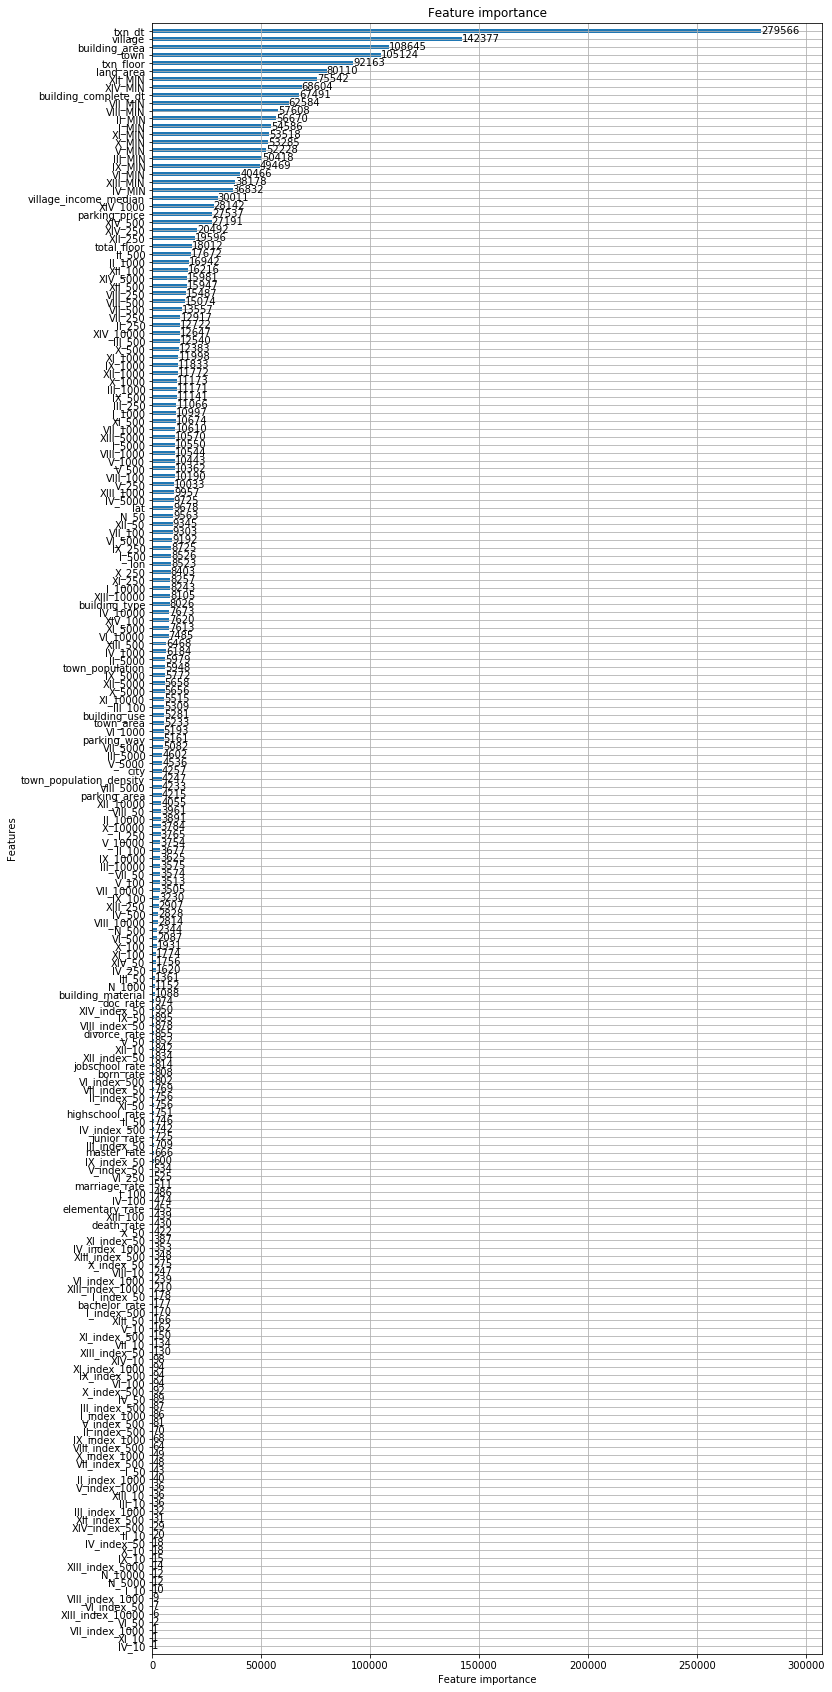

In [19]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5)
plt.show()

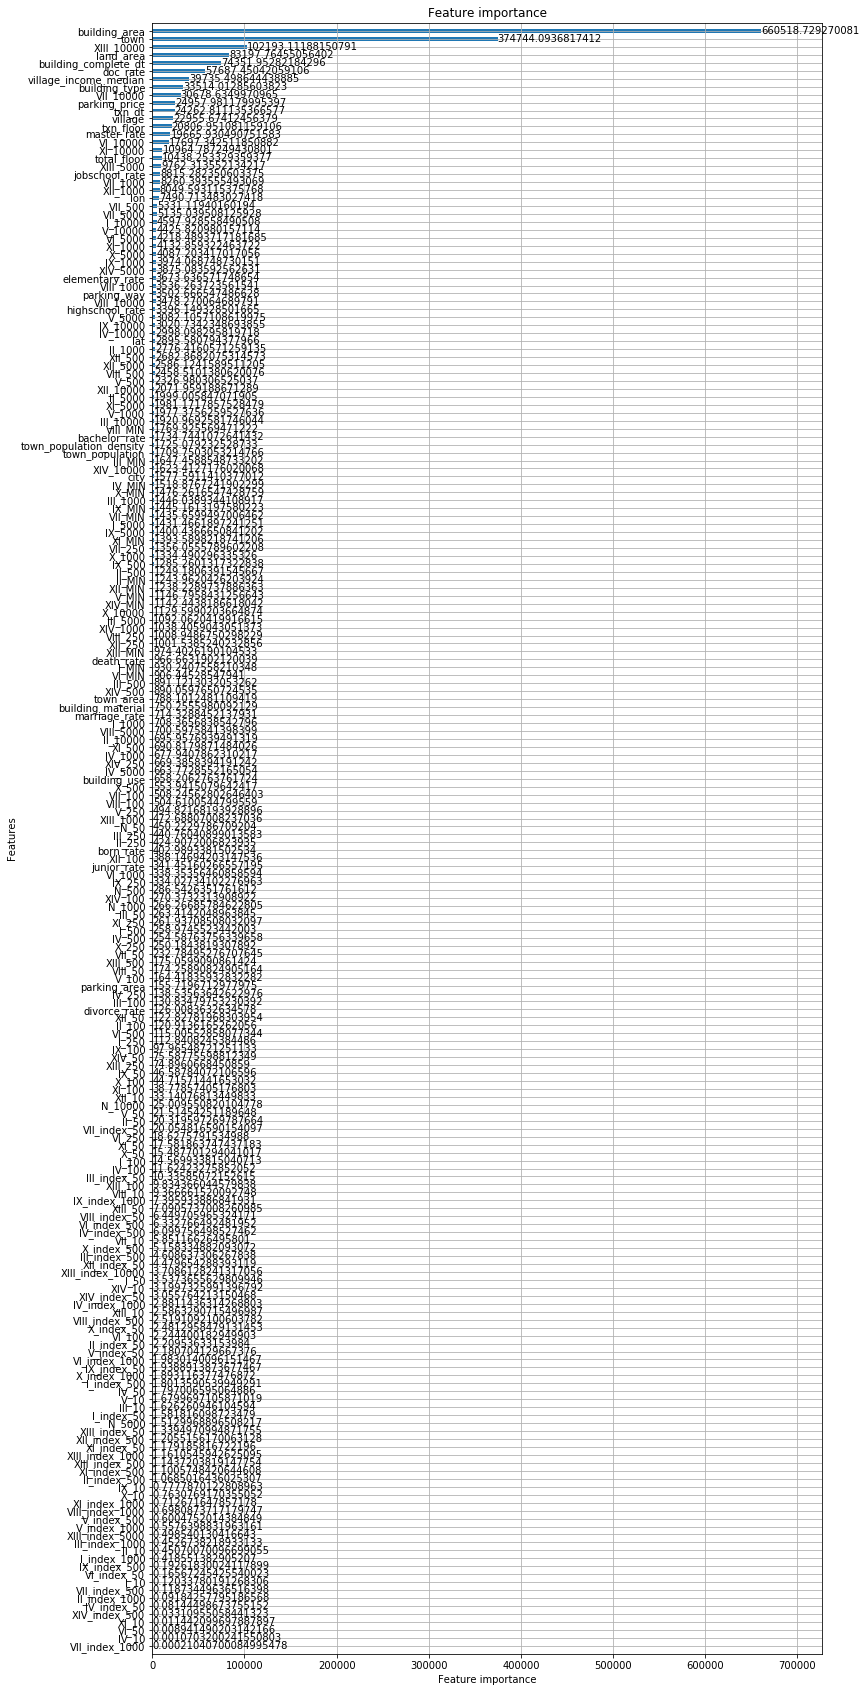

In [30]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='gain')
plt.show()

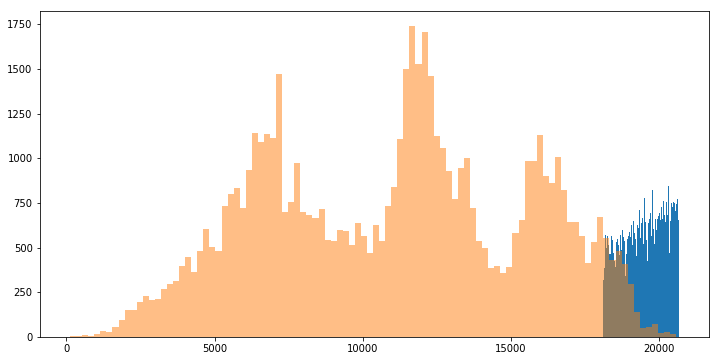

In [23]:
plt.figure(figsize=(12, 6))
plt.hist(df['txn_dt'], bins=100)
plt.hist(df['building_complete_dt'], bins=100, alpha=0.5)
plt.show()

In [28]:
(df['txn_dt'].max() - df['txn_dt'].min())/365

6.994520547945205

In [25]:
df['building_complete_dt'].max()

20577.0

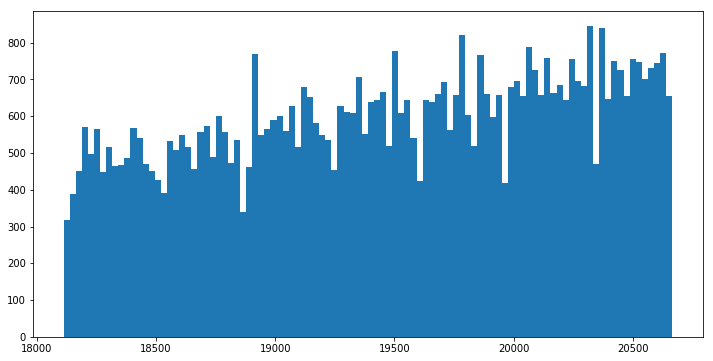

In [21]:
plt.figure(figsize=(12, 6))
plt.hist(df['txn_dt'], bins=100)
plt.show()

In [22]:
1558256923 / 3600 / 24


18035.38105324074

In [ ]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='')
plt.show()